<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Check-your-sample-table-(i.e.-metadata-file)" data-toc-modified-id="Check-your-sample-table-(i.e.-metadata-file)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Check your sample table (i.e. metadata file)</a></span></li><li><span><a href="#Check-your-TRN" data-toc-modified-id="Check-your-TRN-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Check your TRN</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Load the data</a></span></li></ul></li><li><span><a href="#Regulatory-iModulons" data-toc-modified-id="Regulatory-iModulons-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Regulatory iModulons</a></span></li><li><span><a href="#Functional-iModulons" data-toc-modified-id="Functional-iModulons-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Functional iModulons</a></span><ul class="toc-item"><li><span><a href="#GO-Enrichments" data-toc-modified-id="GO-Enrichments-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>GO Enrichments</a></span></li><li><span><a href="#KEGG-Enrichments" data-toc-modified-id="KEGG-Enrichments-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>KEGG Enrichments</a></span><ul class="toc-item"><li><span><a href="#Load-KEGG-mapping" data-toc-modified-id="Load-KEGG-mapping-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Load KEGG mapping</a></span></li><li><span><a href="#Perform-enrichment" data-toc-modified-id="Perform-enrichment-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Perform enrichment</a></span></li><li><span><a href="#Convert-KEGG-IDs-to-human-readable-names" data-toc-modified-id="Convert-KEGG-IDs-to-human-readable-names-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Convert KEGG IDs to human-readable names</a></span></li><li><span><a href="#Save-files" data-toc-modified-id="Save-files-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Save files</a></span></li></ul></li></ul></li><li><span><a href="#Check-for-single-gene-iModulons" data-toc-modified-id="Check-for-single-gene-iModulons-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Check for single gene iModulons</a></span></li><li><span><a href="#Compare-against-published-iModulons" data-toc-modified-id="Compare-against-published-iModulons-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Compare against published iModulons</a></span><ul class="toc-item"><li><span><a href="#Visualize-linked-iModulons" data-toc-modified-id="Visualize-linked-iModulons-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Visualize linked iModulons</a></span></li></ul></li><li><span><a href="#Save-iModulon-object" data-toc-modified-id="Save-iModulon-object-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Save iModulon object</a></span></li><li><span><a href="#Coming-soon" data-toc-modified-id="Coming-soon-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Coming soon</a></span></li></ul></div>

# Setup
This IPython notebook will walk through the steps of characterizing iModulons through semi-automated tools. You will need:
* M and A matrices
* Expression data (e.g. `log_tpm_norm.csv`)
* Gene table and KEGG/GO annotations (Generated in `gene_annotation.ipynb`)
* Sample table, with a column for `project` and `condition`
* TRN file

Optional (not needed, will be generated in the notebook):
* iModulon table (if you already have some characterized iModulons)

In [1]:
from pymodulon.core import IcaData
from os import path
import pandas as pd
import re
from Bio.KEGG import REST
from tqdm.notebook import tqdm

In [2]:
# Enter the location of your data here
data_dir = '../data/'

## Check your sample table (i.e. metadata file)
Your metadata file will probably have a lot of columns, most of which you may not care about. Feel free to save a secondary copy of your metadata file with only columns that seem relevant to you. The two most important columns are:
1. `project`
2. `condition`

Make sure that these columns exist in your metadata file

In [3]:
df_metadata = pd.read_csv(path.join(data_dir,'metadata_qc.csv'),index_col=0)
df_metadata[['project','condition']].head()

,project,condition
SRX3467357,FadR,wt_p
SRX3467358,FadR,wt_p
SRX3467359,FadR,ko_p
SRX3467360,FadR,ko_p
SRX3565164,GDGT,75_2.4_log


In [4]:
print(df_metadata.project.notnull().all())
print(df_metadata.condition.notnull().all())

True
True


## Check your TRN

Each row of the TRN file represents a regulatory interaction.  
**Your TRN file must have the following columns:**
1. `regulator` - Name of regulator (`/` or `+` characters will be converted to `;`)
1. `gene_id` - Locus tag of gene being regulated

The following columns are optional, but are helpful to have:
1. `regulator_id` - Locus tag of regulator
1. `gene_name` - Name of gene (can automatically update this using `name2num`)
1. `direction` - Direction of regulation ('+' for activation, '-' for repression, '?' or NaN for unknown)
1. `evidence` - Evidence of regulation (e.g. ChIP-exo, qRT-PCR, SELEX, Motif search)
1. `PMID` - Reference for regulation

You may add any other columns that could help you. TRNs may be saved as either CSV or TSV files. See below for an example:

In [5]:
df_trn = pd.read_csv(path.join(data_dir,'saci_trn_curated_01_01_2021.tsv'),sep='\t')
df_trn.head()

,regulator,regulator_id,gene_name,gene_id,old_locus_tag,prokka_locus_tag,synonyms,direction,evidence,PMID,additional_notes
0,BarR,SACI_RS10330,barR,SACI_RS10330,Saci_2136,Sacid_02134,NaN,NaN,qRT-PCR,24646198,BarR TF (Lrp/AsnC family transcriptional regul...
1,BarR,SACI_RS10330,spuC,SACI_RS10335,Saci_2137,Sacid_02135,NaN,+,qRT-PCR,24646198,NaN
2,BarR,SACI_RS10330,gltB_1,SACI_RS11230,Saci_2320,Sacid_02323,gltB,+,ChIP-Seq,27502941,NaN
3,BarR,SACI_RS10330,gltB_2,SACI_RS11235,Saci_2321,Sacid_02324,"gltB, purF_3",+,ChIP-Seq,27502941,NaN
4,LrpC,SACI_RS07575,lrpC,SACI_RS07575,Saci_1588,Sacid_01553,Sa-Lrp,NaN,"qRT-PCR, EMSA",23255531,Sa-Lrp TF (Lrp/AsnC family transcriptional reg...


The `regulator` and `gene_id` must be filled in for each row

In [6]:
print(df_trn.regulator.notnull().all())
print(df_trn.gene_id.notnull().all())

True
True


## Load the data
You're now ready to load your IcaData object!

In [7]:
ica_data = IcaData(M = path.join(data_dir,'ica_runs/80/S.csv'),
                   A = path.join(data_dir,'ica_runs/80/A.csv'),
                   X = path.join(data_dir,'log_tpm_norm.csv'),
                   gene_table = path.join(data_dir,'gene_info_curated_Jan_07_2021.tsv'),
                   sample_table = path.join(data_dir,'metadata_qc.csv'),
                   trn = path.join(data_dir,'saci_trn_curated_01_01_2021.tsv'),
                   threshold_method = 'kmeans')

# Regulatory iModulons
Use `compute_trn_enrichment` to automatically check for Regulatory iModulons. The more complete your TRN, the more regulatory iModulons you'll find.

In [8]:
ica_data.compute_trn_enrichment()

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,11,XylR,2.250502e-11,5.401204e-10,0.473684,0.191489,0.272727,9.0,19.0,47.0,1.0
1,12,YtrA-OE,2.737665e-13,6.570397e-12,0.562500,0.243243,0.339623,9.0,16.0,37.0,1.0
2,13,LysM,6.324328e-09,1.517839e-07,0.571429,0.400000,0.470588,4.0,7.0,10.0,1.0
3,27,ArnR;ArnR1,8.720300e-21,2.092872e-19,0.727273,1.000000,0.842105,8.0,11.0,8.0,1.0
4,27,ArnA;ArnB,7.760893e-16,9.313072e-15,0.466667,0.875000,0.608696,7.0,15.0,8.0,1.0
5,29,FadR,1.349778e-37,3.239467e-36,0.791667,0.760000,0.775510,19.0,24.0,25.0,1.0


You can also search for AND/OR combinations of regulators using the `max_regs` argument. Here, we see that iModulon #4 may be regulated by the both ArnR;ArnR1 and ArnA;ArnB.

In [9]:
ica_data.compute_trn_enrichment(max_regs=2)

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,11,XylR,2.250502e-11,3.510782e-09,0.473684,0.191489,0.272727,9.0,19.0,47.0,1.0
1,12,YtrA-OE,2.737665e-13,4.270758e-11,0.562500,0.243243,0.339623,9.0,16.0,37.0,1.0
2,13,LysM,6.324328e-09,9.865951e-07,0.571429,0.400000,0.470588,4.0,7.0,10.0,1.0
3,27,ArnR;ArnR1,8.720300e-21,1.360367e-18,0.727273,1.000000,0.842105,8.0,11.0,8.0,1.0
4,27,ArnR;ArnR1+ArnA;ArnB,9.674248e-19,7.545914e-17,0.875000,0.875000,0.875000,7.0,8.0,8.0,2.0
5,27,ArnA;ArnB,7.760893e-16,4.035664e-14,0.466667,0.875000,0.608696,7.0,15.0,8.0,1.0
6,29,FadR,1.349778e-37,2.105654e-35,0.791667,0.760000,0.775510,19.0,24.0,25.0,1.0


Regulator enrichments can be directly saved to the `imodulon_table` using the `save` argument. This saves the enrichment with the lowest q-value to the table. For iModulon #4, it will automatically save `ArnR;ArnR1` as the enrichment, but we want to save `ArnR;ArnR1+ArnA;ArnB`. We can update our enrichments accordingly, using `compute_regulon_enrichment`:

In [10]:
ica_data.compute_trn_enrichment(max_regs=2,save=True)

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,11,XylR,2.250502e-11,3.510782e-09,0.473684,0.191489,0.272727,9.0,19.0,47.0,1.0
1,12,YtrA-OE,2.737665e-13,4.270758e-11,0.562500,0.243243,0.339623,9.0,16.0,37.0,1.0
2,13,LysM,6.324328e-09,9.865951e-07,0.571429,0.400000,0.470588,4.0,7.0,10.0,1.0
3,27,ArnR;ArnR1,8.720300e-21,1.360367e-18,0.727273,1.000000,0.842105,8.0,11.0,8.0,1.0
4,27,ArnR;ArnR1+ArnA;ArnB,9.674248e-19,7.545914e-17,0.875000,0.875000,0.875000,7.0,8.0,8.0,2.0
5,27,ArnA;ArnB,7.760893e-16,4.035664e-14,0.466667,0.875000,0.608696,7.0,15.0,8.0,1.0
6,29,FadR,1.349778e-37,2.105654e-35,0.791667,0.760000,0.775510,19.0,24.0,25.0,1.0


In [11]:
ica_data.compute_regulon_enrichment(27,'ArnR;ArnR1+ArnA;ArnB',save=True)

pvalue           9.674248e-19
precision        8.750000e-01
recall           8.750000e-01
f1score          8.750000e-01
TP               7.000000e+00
regulon_size     8.000000e+00
imodulon_size    8.000000e+00
n_regs           2.000000e+00
Name: ArnR;ArnR1+ArnA;ArnB, dtype: float64

You can rename iModulons in this jupyter notebook, or you can save the iModulon table as a CSV and edit it in Excel.

In [12]:
reg_entries = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]
reg_entries

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
11,XylR,2.250502e-11,3.510782e-09,0.473684,0.191489,0.272727,9.0,19.0,47.0,1.0
12,YtrA-OE,2.737665e-13,4.270758e-11,0.562500,0.243243,0.339623,9.0,16.0,37.0,1.0
13,LysM,6.324328e-09,9.865951e-07,0.571429,0.400000,0.470588,4.0,7.0,10.0,1.0
27,ArnR;ArnR1+ArnA;ArnB,9.674248e-19,1.360367e-18,0.875000,0.875000,0.875000,7.0,8.0,8.0,2.0
29,FadR,1.349778e-37,2.105654e-35,0.791667,0.760000,0.775510,19.0,24.0,25.0,1.0


In [13]:
ica_data.rename_imodulons(reg_entries.regulator.to_dict())
print(ica_data.imodulon_names[:28])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'XylR', 'YtrA-OE', 'LysM', 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 'ArnR;ArnR1+ArnA;ArnB']


You can also manually rename iModulons with long names

In [14]:
ica_data.rename_imodulons({'ArnR;ArnR1+ArnA;ArnB':'ArnRAB'})

In [15]:
ica_data.imodulon_names[27]

'ArnRAB'

# Functional iModulons

## GO Enrichments

The `GO_annotations.csv` file was created from `gene_annotation.ipynb`.

In [16]:
DF_GO = pd.read_csv(path.join(data_dir,'GO_annotations.csv'),index_col=0)
DF_GO.head()

,gene_id,gene_ontology
0,SACI_RS05325,glycerol kinase activity
1,SACI_RS05325,glycerol metabolic process
2,SACI_RS05525,maltose alpha-glucosidase activity
3,SACI_RS05590,protein binding
4,SACI_RS05600,identical protein binding


In [17]:
DF_GO.gene_id

0     SACI_RS05325
1     SACI_RS05325
2     SACI_RS05525
3     SACI_RS05590
4     SACI_RS05600
5     SACI_RS05610
6     SACI_RS08005
7     SACI_RS08005
8     SACI_RS09830
9     SACI_RS09830
10    SACI_RS10085
11    SACI_RS10085
12    SACI_RS10975
13    SACI_RS10975
14    SACI_RS10975
15    SACI_RS10980
16    SACI_RS10980
17    SACI_RS10980
18    SACI_RS10985
19    SACI_RS10985
20    SACI_RS10985
21    SACI_RS02915
22    SACI_RS00265
23    SACI_RS00265
24    SACI_RS00265
25    SACI_RS00265
26    SACI_RS00925
27    SACI_RS00925
28    SACI_RS00925
29    SACI_RS01090
30    SACI_RS01090
31    SACI_RS02225
32    SACI_RS10090
33    SACI_RS10090
34    SACI_RS00815
35    SACI_RS00815
Name: gene_id, dtype: object

In [18]:
DF_GO_enrich = ica_data.compute_annotation_enrichment(DF_GO,'gene_ontology')

In [19]:
DF_GO_enrich.to_csv(path.join(data_dir,'GO_enrichments.csv'))

## KEGG Enrichments

### Load KEGG mapping
The `kegg_mapping.csv` file was created from `gene_annotation.ipynb`. This contains KEGG orthologies, pathways, modules, and reactions. Only pathways and modules are relevant to iModulon characterization.

In [20]:
DF_KEGG = pd.read_csv(path.join(data_dir,'kegg_mapping.csv'),index_col=0)
print(DF_KEGG.database.unique())
DF_KEGG.head()

['KEGG_pathway' 'KEGG_module' 'KEGG_reaction']


,gene_id,database,kegg_id
1045,SACI_RS00040,KEGG_pathway,map00760
1046,SACI_RS00040,KEGG_pathway,map01100
1048,SACI_RS00060,KEGG_pathway,map00230
1050,SACI_RS00070,KEGG_pathway,map03410
1055,SACI_RS00085,KEGG_pathway,map00361


In [21]:
kegg_pathways = DF_KEGG[DF_KEGG.database == 'KEGG_pathway']
kegg_modules = DF_KEGG[DF_KEGG.database == 'KEGG_module']

### Perform enrichment
Uses the `compute_annotation_enrichment` function

In [22]:
DF_pathway_enrich = ica_data.compute_annotation_enrichment(kegg_pathways,'kegg_id')
DF_module_enrich = ica_data.compute_annotation_enrichment(kegg_modules,'kegg_id')

In [23]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,4,map00740,8.500350e-05,1.674569e-02,0.333333,0.333333,0.333333,2.0,6.0,6.0
1,7,map00720,1.947367e-11,3.836313e-09,0.169811,0.529412,0.257143,9.0,53.0,17.0
2,7,map01120,1.296231e-08,1.026232e-06,0.067114,0.588235,0.120482,10.0,149.0,17.0
3,7,map01200,1.562789e-08,1.026232e-06,0.082569,0.529412,0.142857,9.0,109.0,17.0
4,7,map00261,7.608847e-04,2.997886e-02,0.333333,0.117647,0.173913,2.0,6.0,17.0


In [24]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,4,M00125,5.693334e-06,9.678668e-04,1.000000,0.333333,0.500000,2.0,2.0,6.0
1,7,M00375,3.286981e-14,5.587867e-12,0.321429,0.529412,0.400000,9.0,28.0,17.0
2,7,M00374,1.771895e-06,1.506111e-04,0.161290,0.294118,0.208333,5.0,31.0,17.0
3,7,M00033,3.070233e-04,1.237299e-02,0.500000,0.117647,0.190476,2.0,4.0,17.0
4,7,M00525,5.094759e-04,1.237299e-02,0.400000,0.117647,0.181818,2.0,5.0,17.0


### Convert KEGG IDs to human-readable names

In [25]:
for idx,key in tqdm(DF_pathway_enrich.kegg_id.items(),total=len(DF_pathway_enrich)):
    text = REST.kegg_find('pathway',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_pathway_enrich.loc[idx,'pathway_name'] = name
    except AttributeError:
        DF_pathway_enrich.loc[idx,'pathway_name'] = None
    
for idx,key in tqdm(DF_module_enrich.kegg_id.items(),total=len(DF_module_enrich)):
    text = REST.kegg_find('module',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_module_enrich.loc[idx,'module_name'] = name
    except AttributeError:
        DF_module_enrich.loc[idx,'module_name'] = None

In [26]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
0,4,map00740,8.500350e-05,1.674569e-02,0.333333,0.333333,0.333333,2.0,6.0,6.0,Riboflavin metabolism
1,7,map00720,1.947367e-11,3.836313e-09,0.169811,0.529412,0.257143,9.0,53.0,17.0,Carbon fixation pathways in prokaryotes
2,7,map01120,1.296231e-08,1.026232e-06,0.067114,0.588235,0.120482,10.0,149.0,17.0,Microbial metabolism in diverse environments
3,7,map01200,1.562789e-08,1.026232e-06,0.082569,0.529412,0.142857,9.0,109.0,17.0,Carbon metabolism
4,7,map00261,7.608847e-04,2.997886e-02,0.333333,0.117647,0.173913,2.0,6.0,17.0,Monobactam biosynthesis


In [27]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
0,4,M00125,5.693334e-06,9.678668e-04,1.000000,0.333333,0.500000,2.0,2.0,6.0,"Riboflavin biosynthesis, plants and bacteria, ..."
1,7,M00375,3.286981e-14,5.587867e-12,0.321429,0.529412,0.400000,9.0,28.0,17.0,Hydroxypropionate-hydroxybutylate cycle
2,7,M00374,1.771895e-06,1.506111e-04,0.161290,0.294118,0.208333,5.0,31.0,17.0,Dicarboxylate-hydroxybutyrate cycle
3,7,M00033,3.070233e-04,1.237299e-02,0.500000,0.117647,0.190476,2.0,4.0,17.0,"Ectoine biosynthesis, aspartate => ectoine"
4,7,M00525,5.094759e-04,1.237299e-02,0.400000,0.117647,0.181818,2.0,5.0,17.0,"Lysine biosynthesis, acetyl-DAP pathway, aspar..."


### Save files

In [28]:
DF_pathway_enrich.to_csv(path.join(data_dir,'kegg_pathway_enrichments.csv'))
DF_pathway_enrich.to_csv(path.join(data_dir,'kegg_module_enrichments.csv'))

# Check for single gene iModulons

In [29]:
sg_imods = ica_data.find_single_gene_imodulons(save=True)

In [30]:
for i,mod in enumerate(sg_imods):
    ica_data.rename_imodulons({mod:'single_gene_'+str(i+1)})

In [31]:
ica_data.imodulon_names

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 'XylR',
 'YtrA-OE',
 'LysM',
 14,
 'single_gene_1',
 'single_gene_2',
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 'single_gene_3',
 25,
 26,
 'ArnRAB',
 'single_gene_4',
 'FadR',
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 'single_gene_5',
 41,
 42,
 'single_gene_6',
 44]

# Compare against published iModulons
We can use the `compare_ica` function to compare iModulons across different organisms. To do so, you must provide the path to a Bidirection Best Hist CSV between your two organisms of interest.

A Github repository containing many BBH CSV's can be found at the following
link: https://github.com/SBRG/modulome_compare_data/tree/master/bbh_csv

You can also provide a path to your own BBH file, as long as it contains the
columns "**gene**" and "**target**"

See the `Tutorial.ipynb` notebook for more information

In [32]:
from pymodulon.compare import *
from pymodulon.io import *

In [33]:
ecoli_data = load_json_model('../example_data/example.json')

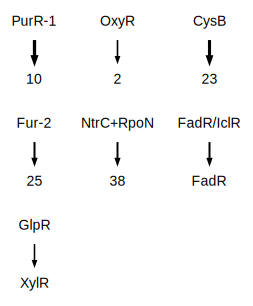

In [34]:
dots,links = compare_ica(ecoli_data.M, ica_data.M, cutoff=0.3,
                         ortho_file = '../example_data/example_bbh.csv')
dots

In the above plot, the top named iModulons are from *E. coli* and the bottom iModulons are from our target organism. Note that the two FadR iModulons are linked together. This `links` variable contains all pairs of iModulons that are linked together

In [35]:
links

[('GlpR', 'XylR', 0.3067430727683906),
 ('OxyR', 2, 0.32441595386469374),
 ('PurR-1', 10, 0.6533523554798281),
 ('CysB', 23, 0.6176360657152683),
 ('NtrC+RpoN', 38, 0.3907067688896174),
 ('Fur-2', 25, 0.4045954149766545),
 ('FadR/IclR', 'FadR', 0.39750691518554093)]

In [36]:
for ecoli_mod,target_mod,dist in links:
    ica_data.imodulon_table.loc[target_mod,'ecoli_ortholog'] = ecoli_mod
ica_data.imodulon_table

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs,single_gene,ecoli_ortholog
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OxyR
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Visualize linked iModulons

In [37]:
from pymodulon.plotting import *

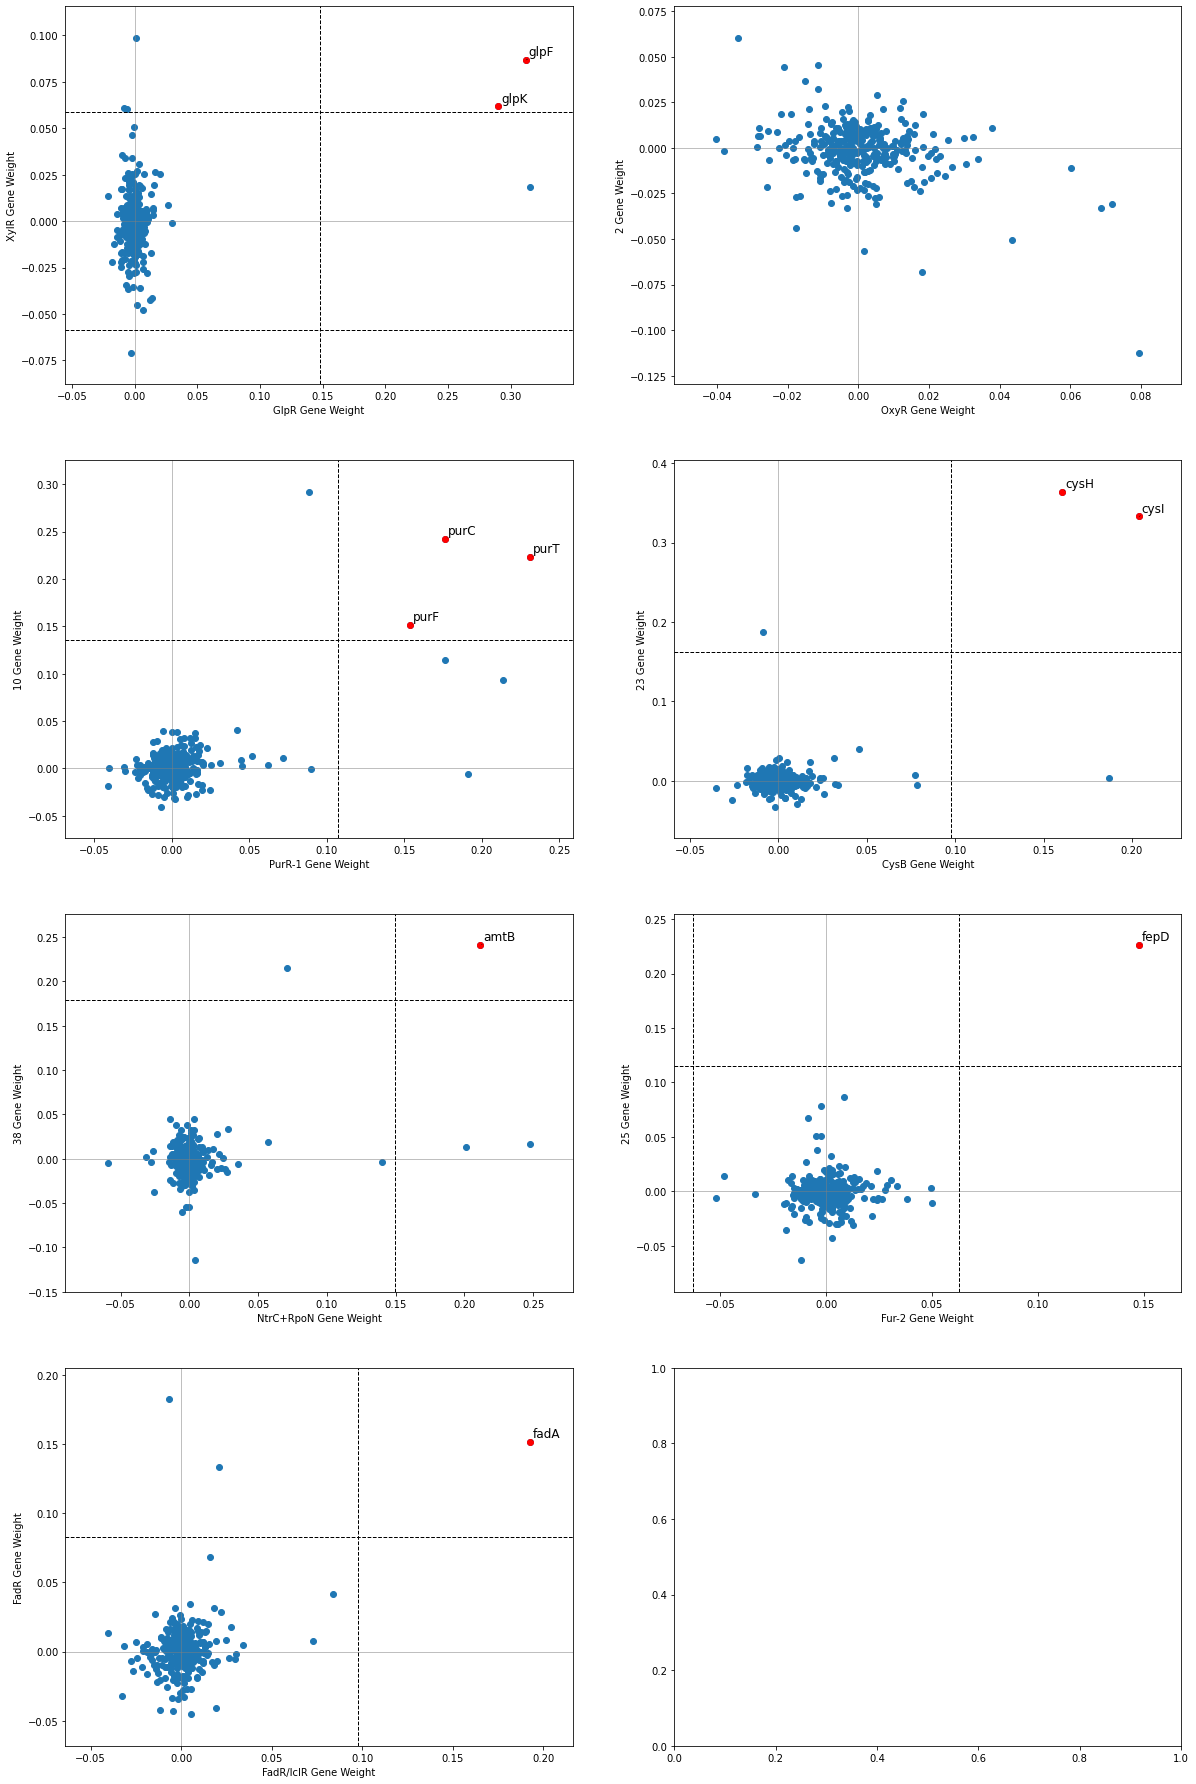

In [38]:
# Number of Columns: 2

# Number of Rows:
num_rows = np.int(np.ceil(len(links) / 2))

# Plot figures
fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(20, 8*num_rows))

counter = 0
for ecoli_mod,saci_mod,_ in links:
    
    if counter % 2 == 0:
        r = np.int(counter / 2)
        c = 0
    else:
        r = np.int((counter - 1) / 2)
        c = 1
    
    compare_gene_weights(ica_data = ecoli_data,imodulon1=ecoli_mod,
                         ica_data2 = ica_data,imodulon2=saci_mod,
                         ortho_file ='../example_data/example_bbh.csv',
                         ax=axs[r, c])
    
    counter += 1

# Save iModulon object

This will save your iModulon table, your thresholds, and any other information stored in the ica_data object.

In [39]:
save_to_json(ica_data,'../data/saci_ica_data.json')

If you prefer to view and edit your iModulon table in excel, save it as a CSV and reload the iModulon as before

In [40]:
ica_data.imodulon_table.to_csv('../data/iModulon_table.csv')

# Coming soon

1. Saving GO/KEGG enrichments to iModulon table
1. Plotting iModulon gene weights across organisms
1. Using iModulon activities to characterize iModulons
1. Finding motifs using MEME
1. Building iModulonDB web pages


---

# Characterize iModulons

## Known iModulons

### iModulon 27: ArnRAB

**The Archaellum Regulatory Network iModulon:**

Contains the Arn operon genes (Saci_1172 to Saci_1179). This operon, activated by ArnR/ArnR1 and repressed by ArnA/ArnB, is necessary for the generation of archaella, bacterial type-IV pili that function as flagella for this organism.

This iModulon differs from its regulons as it does not contain the transcription factors ArnR, ArnR1, ArnS, ArnA, ArnB and their phosphorylators ArnC, ArnD, Saci_pp2a, Saci_1208, and Saci_1209

As expected from literature, this iModulon's activity increases during nutrient limitation conditions and is generally higher in the stationary phase vs log phase as archaella are used by Saci to move around and find food in their environment.

<AxesSubplot:xlabel='Gene Start', ylabel='ArnRAB Gene Weight'>

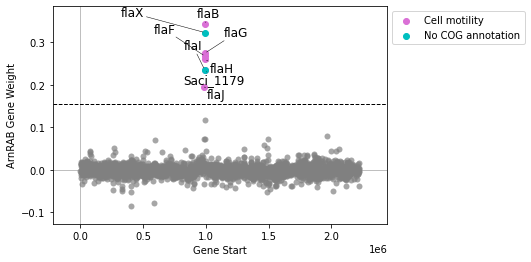

In [41]:
plot_gene_weights(ica_data, 'ArnRAB')

<AxesSubplot:ylabel='ArnRAB iModulon\nActivity'>

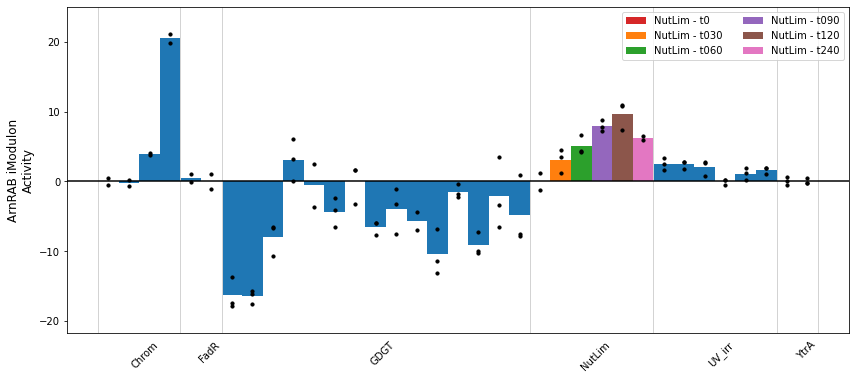

In [42]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'ArnRAB', highlight='NutLim', ax=ax)

### iModulon 29: FadR

**Fatty Acid Degradation Repressor iModulon**

Contains the FadR gene cluster, as well as a few other acyl-CoA ligases. Notably does not contain the fadR gene itself. FadR is a repressor that inhibits fatty acid breakdown genes from activating unless there is a high concentration of medium- to long-chain acyl-CoA in the cytosol.

This iModulon also does not contains 13 genes found in the regulon, many being hyrolases and short-chain-dehydrogenase oxidoreductases. This suggests that short-chain fatty acids may be regulated by another transcription factor. Additionally, the iModulon contains 6 genes that are not in the regulon, all of which are hypothetical proteins with little known about them.

The FadR iModulon has its highest activity in fadR deletion strains in both the `Chrom` and `FadR` projects, with the `NutLim` project being fairly high as well. This suggests that the iModulon is upregulated when the FadR gene cluster is actively expressed (i.e. high conc of med- and long-chain acyl-CoA or during nutrient limitation when fatty acids must be broken down as an alternative energy source).

<AxesSubplot:xlabel='Gene Start', ylabel='FadR Gene Weight'>

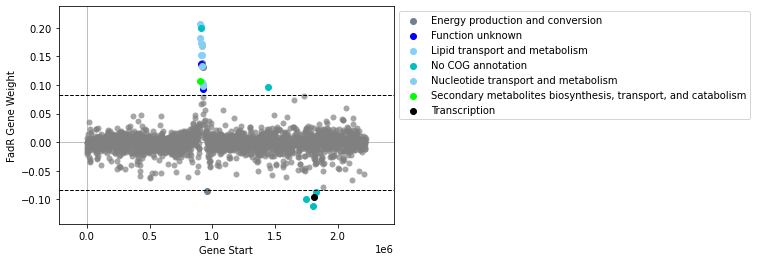

In [43]:
plot_gene_weights(ica_data, 'FadR')

<AxesSubplot:ylabel='FadR iModulon\nActivity'>

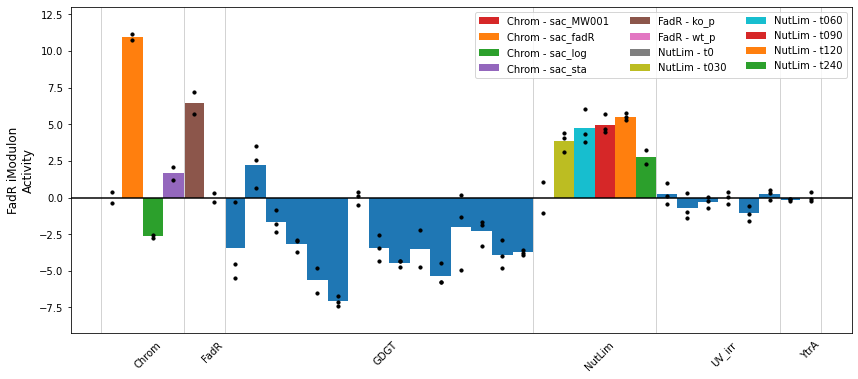

In [44]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'FadR', highlight=['Chrom', 'FadR', 'NutLim'], ax=ax)

### iModulon 24: FadR-KO iModulon

**FadR TF iModulon**

Contains only 1 gene, __Saci_1107__, which codes for FadR

The activity of this iModulon is similar to the FadR iModulon, with the notable exception of the FadR-KO experiment having a substantially negative activity.

In [45]:
ica_data.rename_imodulons({'single_gene_3':'FadR-KO'})

<AxesSubplot:xlabel='Gene Start', ylabel='FadR-KO Gene Weight'>

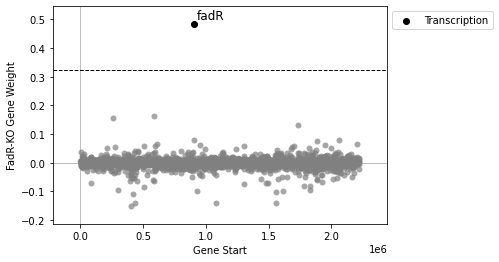

In [46]:
plot_gene_weights(ica_data, 'FadR-KO')

<AxesSubplot:ylabel='FadR-KO iModulon\nActivity'>

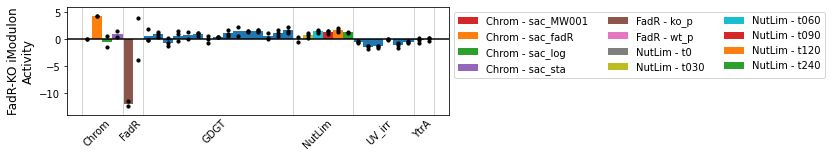

In [47]:
plot_activities(ica_data, 'FadR-KO', highlight=['Chrom', 'FadR', 'NutLim'])

## KEGG enrichment-based iModulons

In [48]:
set(DF_pathway_enrich['imodulon'])

{10, 17, 19, 21, 23, 25, 26, 31, 39, 4, 7, 9, 'LysM', 'XylR'}

In [49]:
set(DF_module_enrich['imodulon'])

{10, 17, 19, 21, 23, 25, 31, 4, 7, 9, 'LysM', 'XylR'}

Of the different iModulons with KEGG enrichments, 4 of them also have E coli orthologs (iModulons 10, 'XylR', 'LysM', and 25).
We will examine these first (along with iModulon 12, 'YtrA-OE)

### iModulon 12: YtrA-OE

Saci_1821 (DNA polymerase) and Saci_0044 (Inosine-5'-monophosphate dehydrogenase) are involved in this iModulon. This suggests a relation to DNA/GTP synthesis

Zn, Mn, and Fe dependent genes are also present, suggesting a role as a metal-uptake / redox regulation for this iModulon.

Given its large size (37), this suggess that the YtrA-OE iModulon is potentially a stress-related iModulon or a composite iModulon which will split up if we add more RNA-Seq data

In [50]:
from pymodulon.util import explained_variance

explained_variance(ica_data, imodulons=['ArnRAB', 'FadR', 'FadR-KO', 'YtrA-OE', 'XylR', 'LysM', 10, 2, 23, 18])

22.86546653359328

In [51]:
ica_data.imodulon_table.loc['YtrA-OE']

regulator             YtrA-OE
pvalue            2.73767e-13
qvalue            4.27076e-11
precision              0.5625
recall               0.243243
f1score              0.339623
TP                          9
regulon_size               16
imodulon_size              37
n_regs                      1
single_gene               NaN
ecoli_ortholog            NaN
Name: YtrA-OE, dtype: object

<AxesSubplot:xlabel='Gene Start', ylabel='YtrA-OE Gene Weight'>

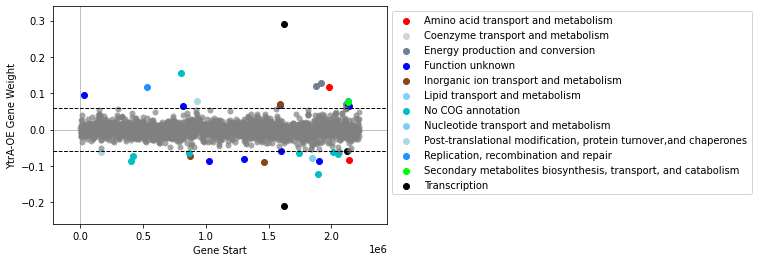

In [52]:
plot_gene_weights(ica_data, 'YtrA-OE')

<AxesSubplot:ylabel='YtrA-OE iModulon\nActivity'>

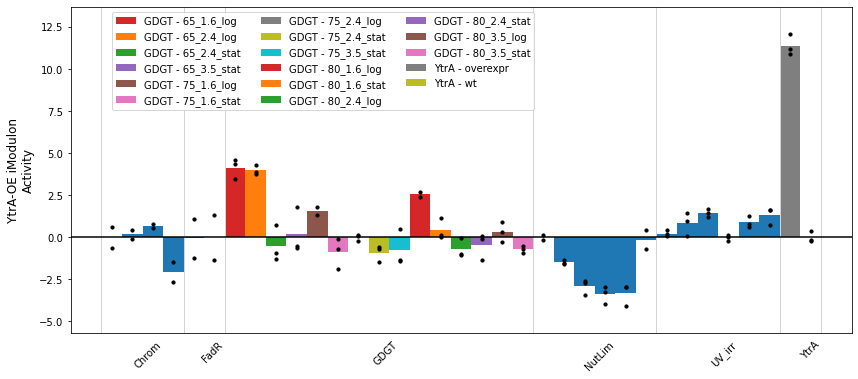

In [53]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'YtrA-OE', highlight=['GDGT', 'YtrA'], ax=ax,
                legend_kwargs={'bbox_to_anchor': (0.6, 1)})

In [54]:
# Uncomment to see the genes involved in this iModulon #

# imod = 'YtrA-OE'

# imod_genes = ica_data.M_binarized[imod][ica_data.M_binarized[imod] > 0].index

# ica_data.gene_table.loc[imod_genes].sort_values(by='old_locus_tag')

### iModulon 10: Purine-related

- E coli ortholog with PurR-1

- PurF_2, PurD, PurM, PurB, PurA, PurE, PurK not invovled in this iModulon


- Lowering the threshold to 0.08 adds the following:
    - guaA_1 (7-cyano-7-deazaguanine synthase aka queC)
    - purF_2
    - purD
    - purM
    - SACI_RS03510
    - SACI_RS11740

- PurABEK not being involved in this iModulon suggests a second Purine-related iModulon (PurR-2?) may also be present (as in the case of E coli)


- Activities Plot shows is purine generation related, as it highly downregulated in stat phase vs log phase
- Also heavily downregulated in periods of starvation and post UV-irradiation

<AxesSubplot:xlabel='Gene Start', ylabel='10 Gene Weight'>

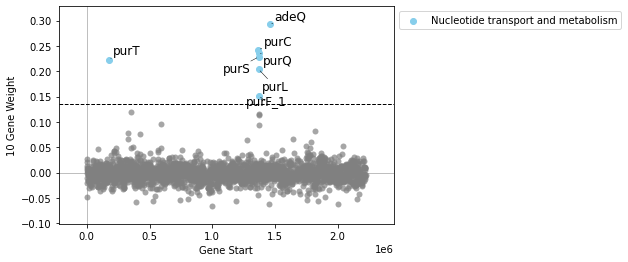

In [55]:
plot_gene_weights(ica_data, 10)

<AxesSubplot:ylabel='10 iModulon\nActivity'>

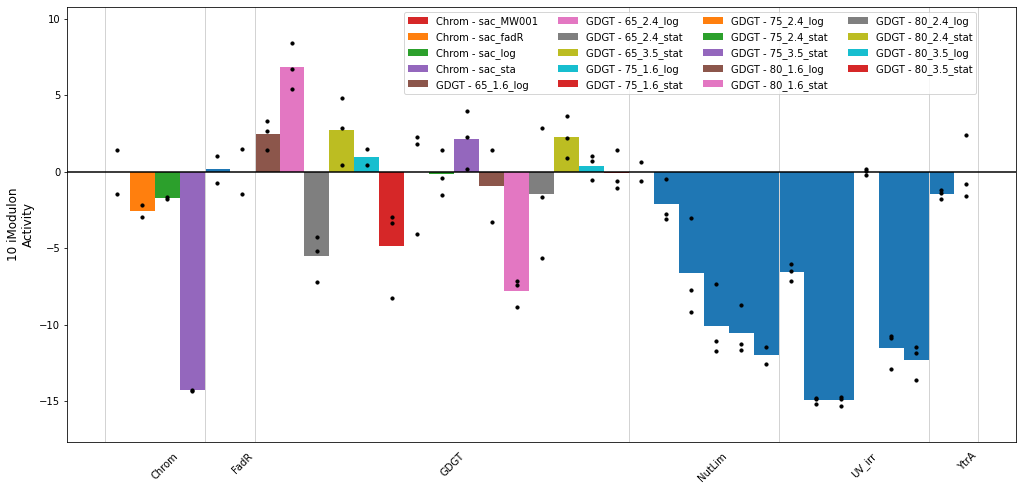

In [56]:
fig, ax = plt.subplots(figsize=(17, 8))

plot_activities(ica_data, 10, highlight=['Chrom', 'GDGT'], ax=ax,
                legend_kwargs={'bbox_to_anchor': (0.35, 1)})

<AxesSubplot:ylabel='10 iModulon\nActivity'>

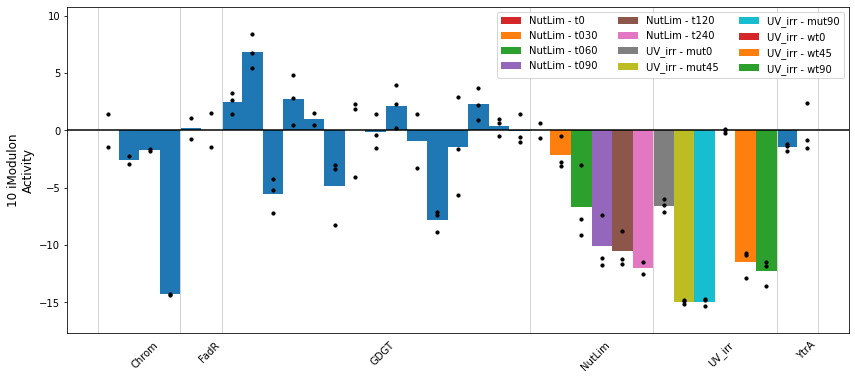

In [57]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 10, highlight=['NutLim', 'UV_irr'], ax=ax)

In [58]:
cond = DF_pathway_enrich['imodulon'] == 10


DF_pathway_enrich[cond].dropna()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
13,10,map00230,4.706404e-08,0.000009,0.111111,0.714286,0.192308,5.0,45.0,7.0,Purine metabolism
15,10,map01110,4.260217e-05,0.002798,0.028902,0.714286,0.055556,5.0,173.0,7.0,Biosynthesis of secondary metabolites


In [59]:
cond = DF_module_enrich['imodulon'] == 10


DF_module_enrich[cond].dropna()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
13,10,M00048,5.075523e-11,8.628390e-09,0.384615,0.714286,0.5,5.0,13.0,7.0,"Inosine monophosphate biosynthesis, PRPP + glu..."


In [60]:
# Uncomment below to see genes in this iModulon #

# imod = 10

# imod_genes = ica_data.M_binarized[imod][ica_data.M_binarized[imod] > 0].index

# ica_data.gene_table.loc[imod_genes]

In [61]:
# iModulon 21 may be another Purine-related iModulon

print(ica_data.imodulons_with('purA'))
print(ica_data.imodulons_with('purB'))
print(ica_data.imodulons_with('purE'))
print(ica_data.imodulons_with('purK'))

[21]
[]
[]
[]


### iModulon 11: XylR / GlpR / Thioredoxin-related

- Many CoA ligases and deghydrogenases
- A few involved with succinate
- Many involved with thioredoxin (some specifically in anerobic conditions)

Possibly a food uptake / biosynthesis iModulon, could also be a redox sensing iModulon


Most likely a composite iModulon

In [62]:
ica_data.imodulon_table.loc['XylR']

regulator                XylR
pvalue             2.2505e-11
qvalue            3.51078e-09
precision            0.473684
recall               0.191489
f1score              0.272727
TP                          9
regulon_size               19
imodulon_size              47
n_regs                      1
single_gene               NaN
ecoli_ortholog           GlpR
Name: XylR, dtype: object

<AxesSubplot:xlabel='Gene Start', ylabel='XylR Gene Weight'>

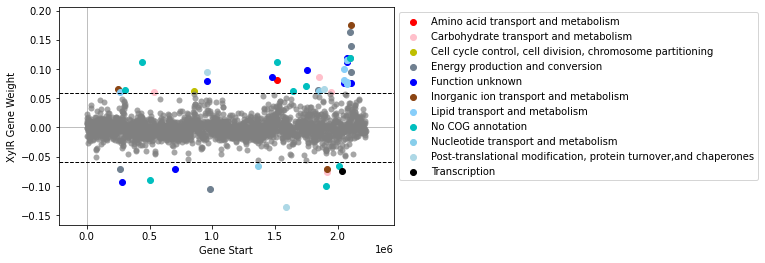

In [63]:
plot_gene_weights(ica_data, 'XylR')

<AxesSubplot:ylabel='XylR iModulon\nActivity'>

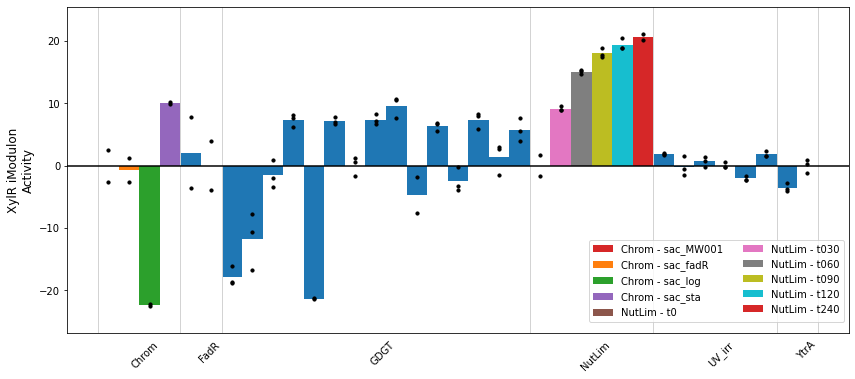

In [64]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'XylR', highlight=['Chrom', 'NutLim'], ax=ax,
                legend_kwargs={'bbox_to_anchor': (1, 0.3)})

<AxesSubplot:ylabel='XylR iModulon\nActivity'>

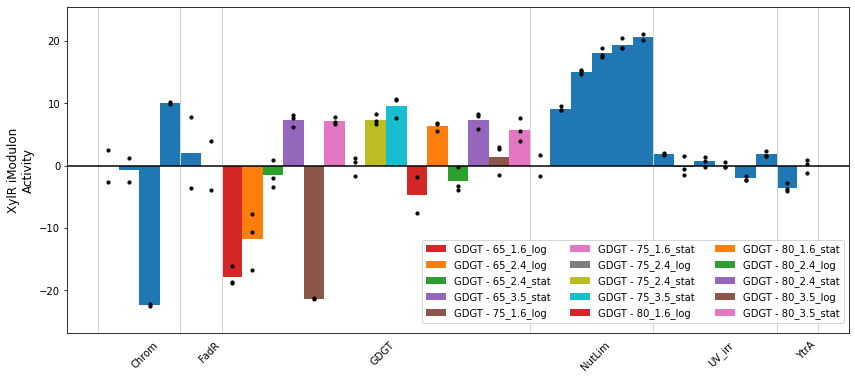

In [65]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'XylR', highlight='GDGT', ax=ax,
                legend_kwargs={'bbox_to_anchor': (1, 0.3)})

In [66]:
cond = DF_pathway_enrich['imodulon'] == 'XylR'


DF_pathway_enrich[cond].dropna()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
16,XylR,map00072,0.000873,0.038839,0.300000,0.063830,0.105263,3.0,10.0,47.0,Synthesis and degradation of ketone bodies
17,XylR,map00310,0.000873,0.038839,0.300000,0.063830,0.105263,3.0,10.0,47.0,Lysine degradation
18,XylR,map00380,0.001183,0.038839,0.272727,0.063830,0.103448,3.0,11.0,47.0,Tryptophan metabolism
19,XylR,map00620,0.001113,0.038839,0.125000,0.106383,0.114943,5.0,40.0,47.0,Pyruvate metabolism
20,XylR,map00640,0.000385,0.038839,0.156250,0.106383,0.126582,5.0,32.0,47.0,Propanoate metabolism
21,XylR,map00720,0.000589,0.038839,0.113208,0.127660,0.120000,6.0,53.0,47.0,Carbon fixation pathways in prokaryotes
22,XylR,map00362,0.001555,0.043752,0.250000,0.063830,0.101695,3.0,12.0,47.0,Benzoate degradation
23,XylR,map02020,0.003079,0.075828,0.200000,0.063830,0.096774,3.0,15.0,47.0,Two-component system
24,XylR,map00900,0.003736,0.081772,0.187500,0.063830,0.095238,3.0,16.0,47.0,Terpenoid backbone biosynthesis


In [67]:
cond = DF_module_enrich['imodulon'] == 'XylR'


DF_module_enrich[cond].dropna()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
14,XylR,M00088,0.000873,0.049459,0.300000,0.063830,0.105263,3.0,10.0,47.0,"Ketone body biosynthesis, acetyl-CoA => acetoa..."
15,XylR,M00373,0.000873,0.049459,0.300000,0.063830,0.105263,3.0,10.0,47.0,Ethylmalonyl pathway
16,XylR,M00416,0.000410,0.049459,1.000000,0.042553,0.081633,2.0,2.0,47.0,Cytochrome aa3-600 menaquinol oxidase
17,XylR,M00155,0.001215,0.051629,0.666667,0.042553,0.080000,2.0,3.0,47.0,"Cytochrome c oxidase, prokaryotes"
18,XylR,M00095,0.001992,0.062403,0.230769,0.063830,0.100000,3.0,13.0,47.0,"C5 isoprenoid biosynthesis, mevalonate pathway"
19,XylR,M00375,0.002202,0.062403,0.142857,0.085106,0.106667,4.0,28.0,47.0,Hydroxypropionate-hydroxybutylate cycle
20,XylR,M00374,0.003236,0.078580,0.129032,0.085106,0.102564,4.0,31.0,47.0,Dicarboxylate-hydroxybutyrate cycle


In [68]:
imod = 'XylR'

imod_genes = ica_data.M_binarized[imod][ica_data.M_binarized[imod] > 0].index

ica_data.gene_table.loc[imod_genes]

,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS01445,moaA_1,Saci_0296,Sacid_00292,NaN,251845.0,252864.0,-,PTO1314 family radical SAM protein,"GTP 3',8-cyclase",Inorganic ion transport and metabolism,A0A0U3H336,NC_007181.1,NaN
SACI_RS01495,acsA_1,Saci_0306,Sacid_00302,acs,260644.0,262641.0,-,acetate--CoA ligase,Acetyl-coenzyme A synthetase,Lipid transport and metabolism,A0A0U3HAP5,NC_007181.1,NaN
SACI_RS01505,Saci_0308,Saci_0308,Sacid_00304,NaN,263557.0,263805.0,+,biotin attachment protein,hypothetical protein,Energy production and conversion,A0A0U2VW51,NC_007181.1,NaN
SACI_RS01585,Saci_0324,Saci_0324,Sacid_00320,NaN,277460.0,278311.0,-,sulfite exporter TauE/SafE family protein,putative membrane transporter protein,Function unknown,A0A0U2VW32,NC_007181.1,NaN
SACI_RS01760,Saci_0360,Saci_0360,Sacid_00355,NaN,303121.0,304209.0,+,hypothetical protein,hypothetical protein,No COG annotation,M1ISI4,NC_007181.1,NaN
SACI_RS11800,SACI_RS11800,NaN,NaN,NaN,442246.0,442317.0,-,hypothetical protein,NaN,No COG annotation,NaN,NC_007181.1,NaN
SACI_RS11555,SACI_RS11555,NaN,NaN,NaN,499991.0,500131.0,+,putative integrase,NaN,No COG annotation,UPI0011BFB8BC,NC_007181.1,NaN
SACI_RS03215,abaF_1,Saci_0675,Sacid_00657,NaN,535612.0,536928.0,-,MFS transporter,Fosfomycin resistance protein AbaF,Carbohydrate transport and metabolism,A0A0U3FWX6,NC_007181.1,NaN
SACI_RS11610,Saci_0873,Saci_0873,Sacid_00851,NaN,700810.0,700977.0,-,YHS domain-containing protein,hypothetical protein,Function unknown,M1ITZ6,NC_007181.1,NaN
SACI_RS05015,parA,Saci_1050,Sacid_01024,NaN,850873.0,852171.0,+,"ParA, chromosome-partioning ATPase, AAA family...",hypothetical protein,"Cell cycle control, cell division, chromosome ...",A0A0U2W2Y0,NC_007181.1,NaN


### iModulon 13: LysM

In [69]:
ica_data.imodulon_table.loc['LysM']

regulator                LysM
pvalue            6.32433e-09
qvalue            9.86595e-07
precision            0.571429
recall                    0.4
f1score              0.470588
TP                          4
regulon_size                7
imodulon_size              10
n_regs                      1
single_gene               NaN
ecoli_ortholog            NaN
Name: LysM, dtype: object

<AxesSubplot:xlabel='Gene Start', ylabel='LysM Gene Weight'>

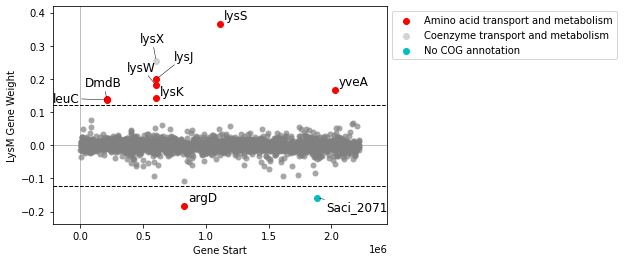

In [70]:
plot_gene_weights(ica_data, 'LysM')

<AxesSubplot:ylabel='LysM iModulon\nActivity'>

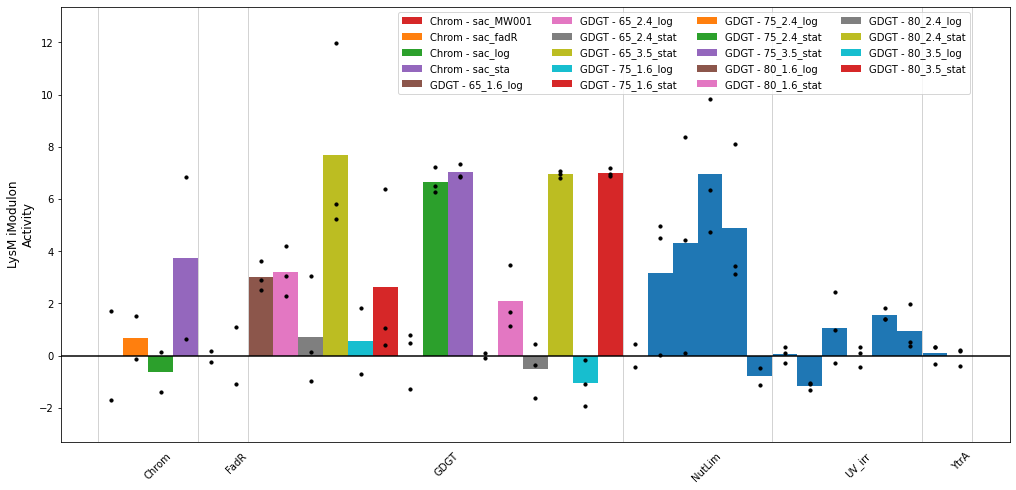

In [107]:
fig, ax = plt.subplots(figsize=(17, 8))

plot_activities(ica_data, 'LysM', highlight=['Chrom', 'GDGT'], ax=ax,
                legend_kwargs={'bbox_to_anchor':(0.35, 1)})

In [71]:
cond = DF_pathway_enrich['imodulon'] == 'LysM'


DF_pathway_enrich[cond].dropna()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
25,LysM,map01210,2.320941e-10,4.572255e-08,0.230769,0.6,0.333333,6.0,26.0,10.0,2-Oxocarboxylic acid metabolism
26,LysM,map01230,4.638471e-07,4.568894e-05,0.068966,0.6,0.123711,6.0,87.0,10.0,Biosynthesis of amino acids
27,LysM,map00290,1.283633e-05,8.429188e-04,0.250000,0.3,0.272727,3.0,12.0,10.0,"Valine, leucine and isoleucine biosynthesis"
28,LysM,map00300,2.636557e-05,1.298504e-03,0.200000,0.3,0.240000,3.0,15.0,10.0,Lysine biosynthesis
29,LysM,map01100,2.963728e-04,1.167709e-02,0.017903,0.7,0.034913,7.0,391.0,10.0,Metabolic pathways
30,LysM,map00660,6.049418e-04,1.986226e-02,0.222222,0.2,0.210526,2.0,9.0,10.0,C5-Branched dibasic acid metabolism
31,LysM,map00220,1.298557e-03,3.654511e-02,0.153846,0.2,0.173913,2.0,13.0,10.0,Arginine biosynthesis
32,LysM,map00966,4.355401e-03,9.982140e-02,1.000000,0.1,0.181818,1.0,1.0,10.0,Glucosinolate biosynthesis
33,LysM,map01110,4.560368e-03,9.982140e-02,0.023121,0.4,0.043716,4.0,173.0,10.0,Biosynthesis of secondary metabolites


In [72]:
cond = DF_module_enrich['imodulon'] == 'LysM'


DF_module_enrich[cond].dropna()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
21,LysM,M00031,6.324328e-09,0.000001,0.571429,0.4,0.470588,4.0,7.0,10.0,"Lysine biosynthesis, mediated by LysW, 2-amino..."
22,LysM,M00432,1.183116e-06,0.000067,0.500000,0.3,0.375000,3.0,6.0,10.0,"Leucine biosynthesis, 2-oxoisovalerate => 2-ox..."
23,LysM,M00763,1.183116e-06,0.000067,0.500000,0.3,0.375000,3.0,6.0,10.0,"Ornithine biosynthesis, mediated by LysW, glut..."
24,LysM,M00535,5.112088e-05,0.002173,0.666667,0.2,0.307692,2.0,3.0,10.0,"Isoleucine biosynthesis, pyruvate => 2-oxobuta..."


## iModulon 2 : Sulfur-Oxidation / ETC related

- Gene cluster / operon from Saci_1858 to Saci_1862 (complex III of the respiratory chain)
- Deals with cytochromes, iron-sulfur proteins, antibiotic biosynthesis mono-oxygenase
- E. coli ortholog with OxyR (score of 0.324)
- Related to log vs stat phases?
    - iModulon activity is heavily downregulated in stationary phase vs log phase
    - Notable exception at 65 C, 1.6 pH, log phase
    - Other downregulated conditions are not as severe but all occur at 1.6 pH,log phase (75 C, 80 C)

<AxesSubplot:xlabel='Gene Start', ylabel='2 Gene Weight'>

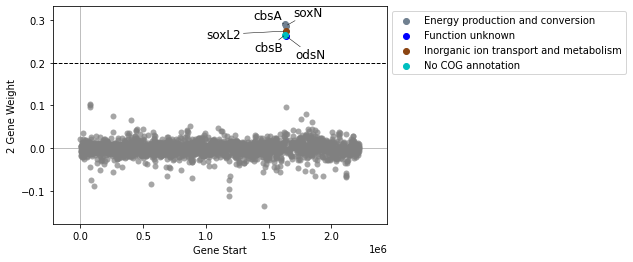

In [108]:
plot_gene_weights(ica_data, 2)

<AxesSubplot:ylabel='2 iModulon\nActivity'>

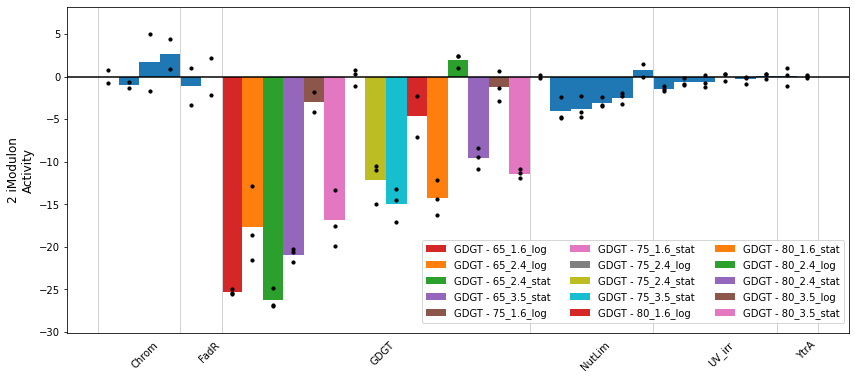

In [112]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 2, highlight='GDGT', ax=ax,
                legend_kwargs={'bbox_to_anchor':(1, 0.3)})

### iModulon 23: CysB / Sulfur Assimilation

In [73]:
cond = DF_pathway_enrich['imodulon'] == 23


DF_pathway_enrich[cond].dropna()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
41,23,map00920,7.583891e-09,0.000001,0.444444,0.500,0.470588,4.0,9.0,8.0,Sulfur metabolism
42,23,map01120,5.148720e-05,0.005071,0.033557,0.625,0.063694,5.0,149.0,8.0,Microbial metabolism in diverse environments


In [74]:
cond = DF_module_enrich['imodulon'] == 23


DF_module_enrich[cond].dropna()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
39,23,M00176,2.779658e-08,0.000005,1.0,0.375,0.545455,3.0,3.0,8.0,"Assimilatory sulfate reduction, sulfate => H2S"


<AxesSubplot:xlabel='Gene Start', ylabel='23 Gene Weight'>

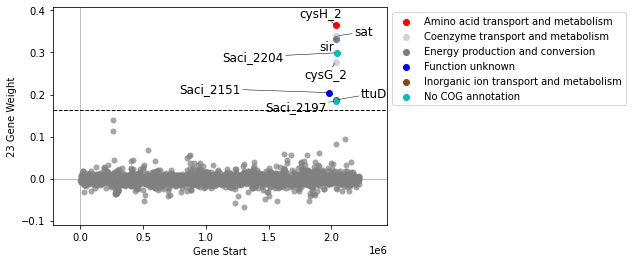

In [75]:
plot_gene_weights(ica_data, 23)

<AxesSubplot:ylabel='23 iModulon\nActivity'>

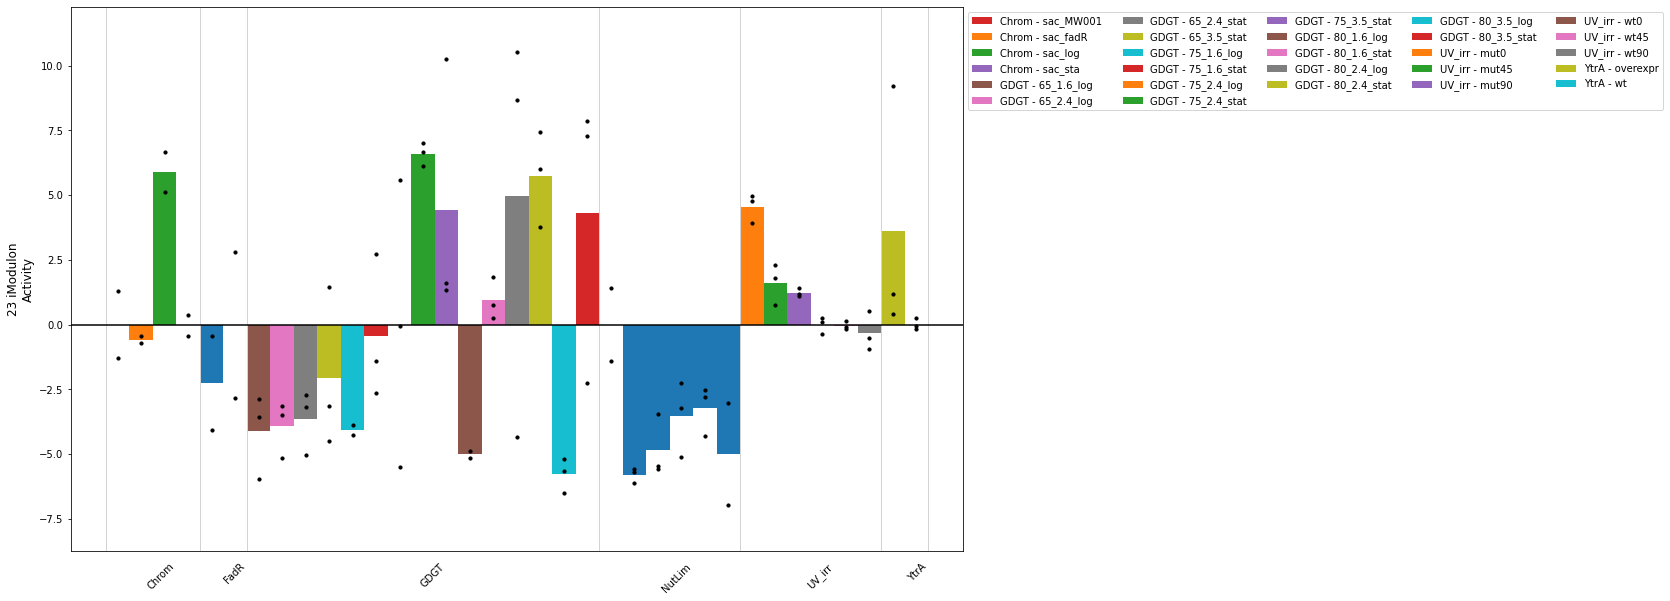

In [115]:
fig, ax = plt.subplots(figsize=(16, 10))

plot_activities(ica_data, 23, highlight=['Chrom', 'GDGT', 'UV_irr', 'YtrA'], ax=ax)

### iModulon 18 (reorganize later)

<AxesSubplot:xlabel='Gene Start', ylabel='18 Gene Weight'>

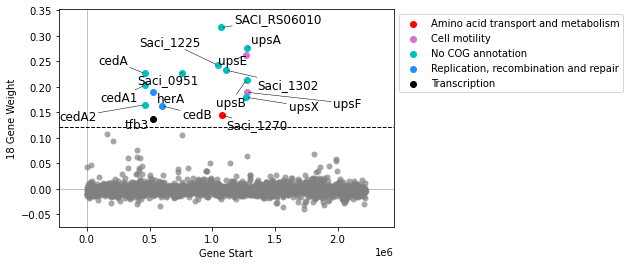

In [116]:
plot_gene_weights(ica_data, 18)

<AxesSubplot:ylabel='18 iModulon\nActivity'>

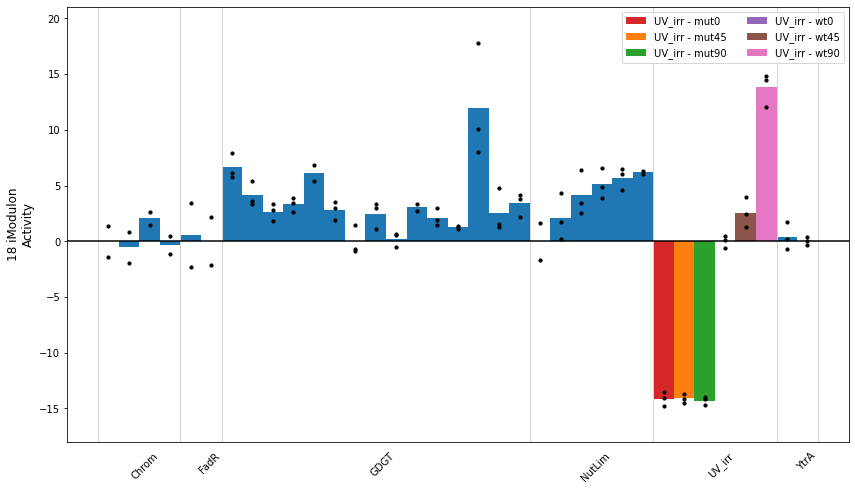

In [119]:
fig, ax = plt.subplots(figsize=(14, 8))

plot_activities(ica_data, 18, highlight='UV_irr', ax=ax)

In [123]:
ica_data.imodulon_table.loc['FadR']

regulator                FadR
pvalue            1.34978e-37
qvalue            2.10565e-35
precision            0.791667
recall                   0.76
f1score               0.77551
TP                         19
regulon_size               24
imodulon_size              25
n_regs                      1
single_gene               NaN
ecoli_ortholog      FadR/IclR
Name: FadR, dtype: object

In [120]:
imod = 18

imod_genes = ica_data.M_binarized[imod][ica_data.M_binarized[imod] > 0].index

ica_data.gene_table.loc[imod_genes]

,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS11810,cedA2,Saci_0567,Sacid_00553,NaN,460159.0,460317.0,-,DNA import protein CedA2,hypothetical protein,No COG annotation,UPI00005522F4,NC_007181.1,NaN
SACI_RS02695,cedA,Saci_0568,Sacid_00554,NaN,460333.0,461115.0,-,DNA import protein CedA,hypothetical protein,No COG annotation,A0A0U3GG40,NC_007181.1,NaN
SACI_RS02700,cedA1,Saci_0569,Sacid_00555,NaN,461116.0,461352.0,-,DNA import protein CedA1,hypothetical protein,No COG annotation,A0A0U3GT29,NC_007181.1,NaN
SACI_RS03170,tfb3,Saci_0665,Sacid_00647,NaN,526865.0,527452.0,+,TFIIB-type zinc ribbon-containing protein,hypothetical protein,Transcription,A0A0U3FEZ6,NC_007181.1,NaN
SACI_RS03180,herA,Saci_0667,Sacid_00649,NaN,529180.0,530820.0,-,"HerA helicase, ATP-binding protein",hypothetical protein,"Replication, recombination and repair",A0A0U3GSV6,NC_007181.1,NaN
SACI_RS03575,cedB,Saci_0748,Sacid_00730,NaN,597891.0,599684.0,+,ATP-binding protein,hypothetical protein,"Replication, recombination and repair",A0A0U3GTT0,NC_007181.1,NaN
SACI_RS04540,Saci_0951,Saci_0951,Sacid_00927,NaN,760719.0,761144.0,-,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3H1M8,NC_007181.1,NaN
SACI_RS05840,Saci_1225,Saci_1225,Sacid_01202,NaN,1042172.0,1042501.0,+,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3F641,NC_007181.1,NaN
SACI_RS06010,SACI_RS06010,NaN,Sacid_01236,NaN,1071231.0,1071434.0,+,hypothetical protein,hypothetical protein,No COG annotation,A0A0U2N8L9,NC_007181.1,NaN
SACI_RS06065,Saci_1270,Saci_1270,Sacid_01247,NaN,1080419.0,1081312.0,+,MFS family permease,hypothetical protein,Amino acid transport and metabolism,A0A0U3HJZ7,NC_007181.1,NaN


### iModulon 25: Fur-2 / Cobalamin (B12) / Osmotic Regulation

In [77]:
cond = DF_pathway_enrich['imodulon'] == 25


DF_pathway_enrich[cond].dropna()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
43,25,map02010,0.000013,0.002529,0.25,0.3,0.272727,3.0,12.0,10.0,ABC transporters


In [78]:
cond = DF_module_enrich['imodulon'] == 25


DF_module_enrich[cond].dropna()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name


<AxesSubplot:xlabel='Gene Start', ylabel='25 Gene Weight'>

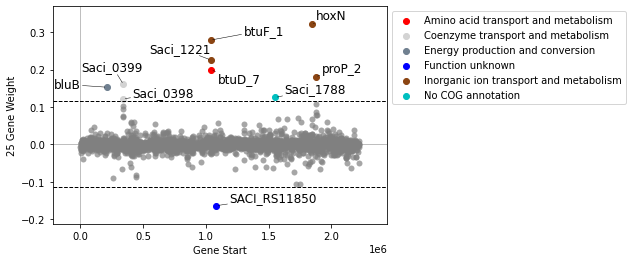

In [79]:
plot_gene_weights(ica_data, 25)

<AxesSubplot:ylabel='25 iModulon\nActivity'>

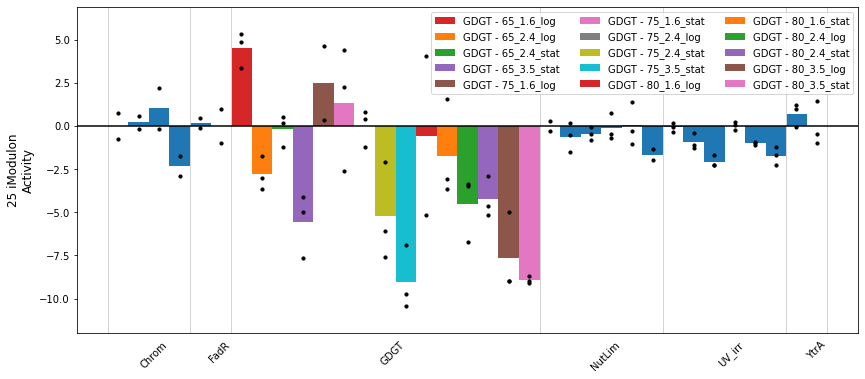

In [80]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 25, highlight='GDGT', ax=ax)

## Remainder iModulons

## iModulon 0

- Only 2 genes!
- Really high activity in GDGT:
    - 75 C, 2.4 pH, stat (highest by far)
    - 75 C, 3.5 pH, stat (distant second)
    - 80 C, 2.4 pH, stat (close third)

- YtrA-OE and FadR-KO no effect on this iModulon (actv of 0)

<AxesSubplot:xlabel='Gene Start', ylabel='0 Gene Weight'>

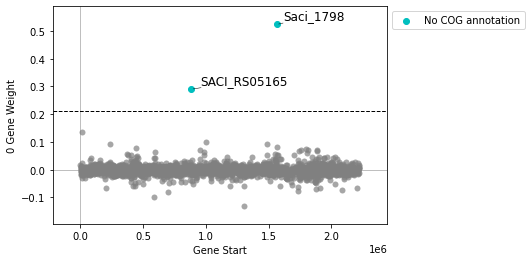

In [81]:
plot_gene_weights(ica_data, 0)

<AxesSubplot:ylabel='0 iModulon\nActivity'>

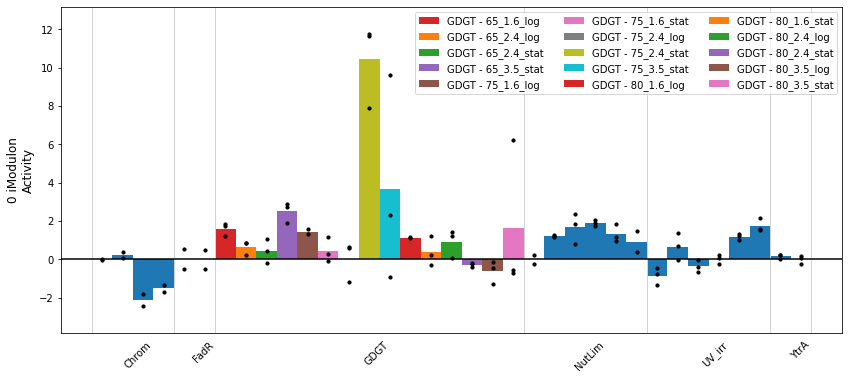

In [82]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 0, highlight='GDGT', ax=ax)

## iModulon 1

- No particular gene clusters
- Possible relation to temperature? Possible relation to pH?
    - GDGT of 65 C are all downregulated
    - 3 of top 4 activities occur at 80 C, the 4th at 75 C
    - 3 of top 4 activities occur at 1.6 pH, the 4th at 3.5 pH

- Clear distinction between log vs stat phases


- Saci_0128 is in this iModulon (supposedly produces sporulation type-II protein M)

<AxesSubplot:xlabel='Gene Start', ylabel='1 Gene Weight'>

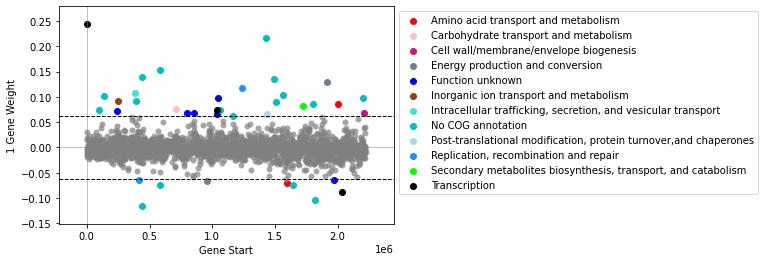

In [83]:
plot_gene_weights(ica_data, 1)

<AxesSubplot:ylabel='1 iModulon\nActivity'>

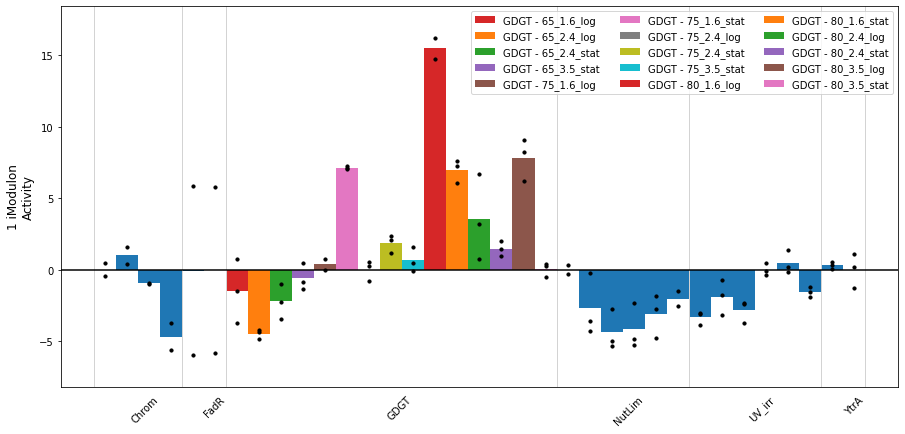

In [84]:
fig, ax = plt.subplots(figsize=(15, 7))

plot_activities(ica_data, 1, highlight='GDGT', ax=ax)

In [85]:
imod = 1

imod_genes = ica_data.M_binarized[imod][ica_data.M_binarized[imod] > 0].index

ica_data.gene_table.loc[imod_genes]

,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS00030,Saci_0006,Saci_0006,Sacid_00006,NaN,3801.0,4052.0,-,winged helix-turn-helix transcriptional regulator,hypothetical protein,Transcription,A0A0U3F8V4,NC_007181.1,NaN
SACI_RS00605,Saci_0128,Saci_0128,Sacid_00123,NaN,99663.0,100643.0,+,stage II sporulation protein M,hypothetical protein,No COG annotation,A0A0U3GMB5,NC_007181.1,NaN
SACI_RS00795,Saci_0167,Saci_0167,Sacid_00161,NaN,136962.0,137603.0,-,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3HB35,NC_007181.1,NaN
SACI_RS01395,Saci_0286,Saci_0286,Sacid_00282,NaN,241651.0,242223.0,-,DedA family protein,hypothetical protein,Function unknown,A0A0U2Y936,NC_007181.1,NaN
SACI_RS01445,moaA_1,Saci_0296,Sacid_00292,NaN,251845.0,252864.0,-,PTO1314 family radical SAM protein,"GTP 3',8-cyclase",Inorganic ion transport and metabolism,A0A0U3H336,NC_007181.1,NaN
SACI_RS02175,Saci_0449,Saci_0449,Sacid_00443,NaN,381830.0,382318.0,+,helix-turn-helix domain-containing protein,hypothetical protein,"Intracellular trafficking, secretion, and vesi...",A0A0U3HAC8,NC_007181.1,NaN
SACI_RS02250,Saci_0464,Saci_0464,Sacid_00458,NaN,392594.0,393088.0,-,hypothetical protein,hypothetical protein,No COG annotation,A0A0U2X0I3,NC_007181.1,NaN
SACI_RS02420,Saci_0503,Saci_0503,Sacid_00497,NaN,417681.0,417860.0,+,hypothetical protein,hypothetical protein,"Replication, recombination and repair",A0A0U3FN09,NC_007181.1,NaN
SACI_RS02570,Saci_0538,Saci_0538,Sacid_00528,NaN,440555.0,440959.0,-,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3F7L4,NC_007181.1,NaN
SACI_RS11800,SACI_RS11800,NaN,NaN,NaN,442246.0,442317.0,-,hypothetical protein,NaN,No COG annotation,NaN,NC_007181.1,NaN


## iModulon 2

- Gene cluster / operon from Saci_1858 to Saci_1862
- Deals with cytochromes, iron-sulfur proteins, antibiotic biosynthesis mono-oxygenase
- E. coli ortholog with OxyR (score of 0.324)
- Related to log vs stat phases?
    - iModulon activity is heavily downregulated in stationary phase vs log phase
    - Notable exception at 65 C, 1.6 pH, log phase
    - Other downregulated conditions are not as severe but all occur at 1.6 pH,log phase (75 C, 80 C)

<AxesSubplot:xlabel='Gene Start', ylabel='2 Gene Weight'>

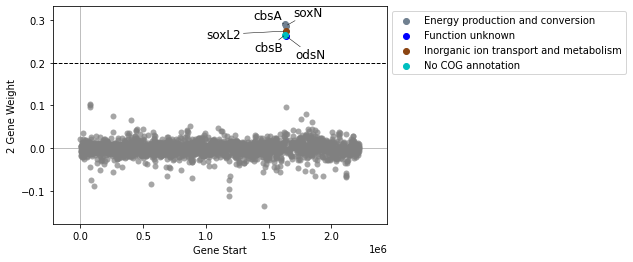

In [86]:
plot_gene_weights(ica_data, 2)

<AxesSubplot:ylabel='2 iModulon\nActivity'>

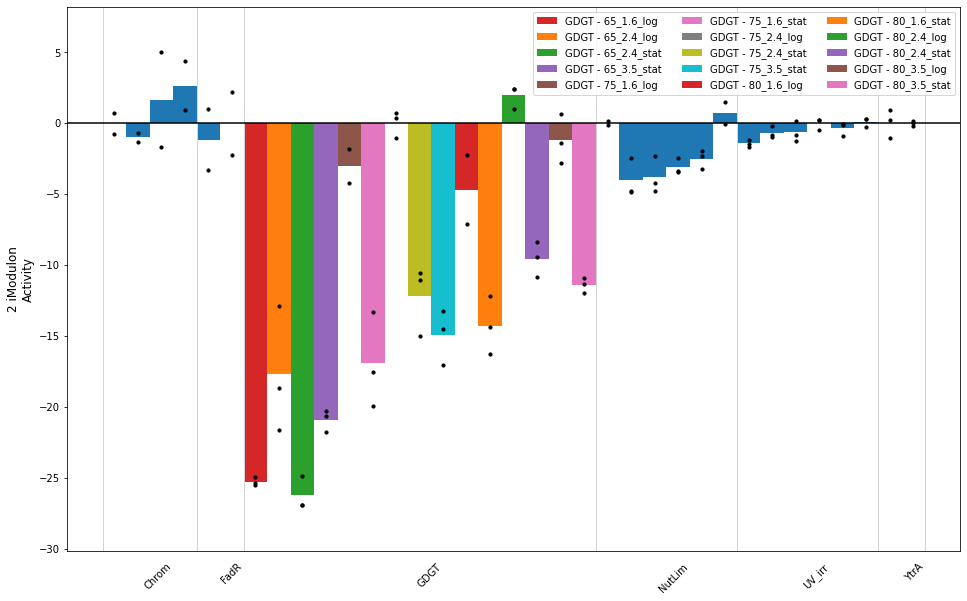

In [87]:
fig, ax = plt.subplots(figsize=(16, 10))

plot_activities(ica_data, 2, highlight='GDGT', ax=ax)

## iModulon 3

- Consists of a gene cluster (Saci_2208, Saci_2211 to Saci_2221, Saci_2223 to Saci_2226)
    - Many of the gene products are fatty-acid oxidation enzymes (x - CoA ligases, peroxidases, alc dehydrogenases)
- spuC (Saci_2137) is present in this iModulon
    - This iModulon could be regulated partially or fully by BarR (Saci_2136), which regulates spuC

<AxesSubplot:xlabel='Gene Start', ylabel='3 Gene Weight'>

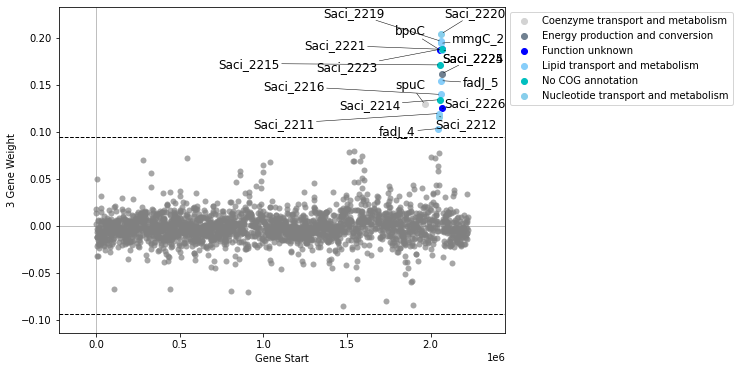

In [88]:
fig, ax = plt.subplots(figsize=(8,6))

plot_gene_weights(ica_data, 3, ax=ax)

In [89]:
ica_data.compute_regulon_enrichment(imodulon=3, regulator='BarR')

pvalue            0.029308
precision         0.250000
recall            0.058824
f1score           0.095238
TP                1.000000
regulon_size      4.000000
imodulon_size    17.000000
n_regs            1.000000
Name: BarR, dtype: float64

<AxesSubplot:ylabel='3 iModulon\nActivity'>

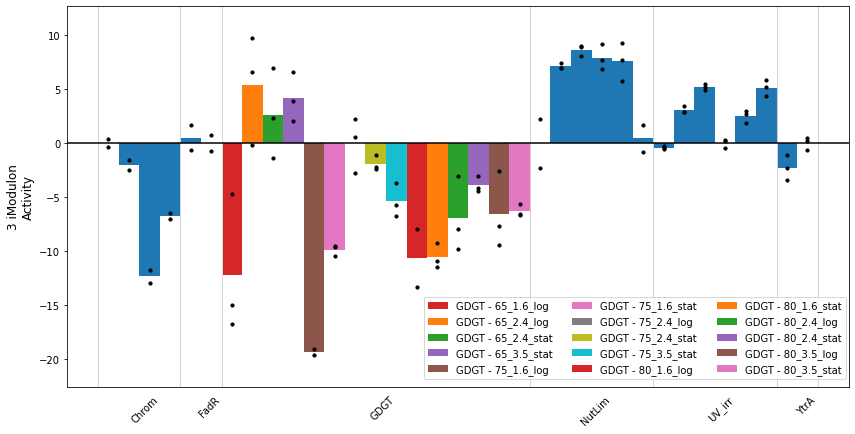

In [90]:
fig, ax = plt.subplots(figsize=(14, 7))

plot_activities(ica_data, 3, highlight='GDGT', ax=ax, legend_kwargs={'bbox_to_anchor': (0.45, 0.25)})

## iModulon 4

- Possibly the riboflavin iModulon
    - Contains ribH and ribB, along with GTP cyclohydrolase and riboflavin synthase (Saci_0821)

<AxesSubplot:xlabel='Gene Start', ylabel='4 Gene Weight'>

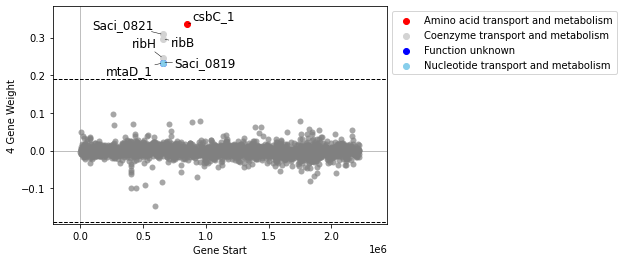

In [91]:
plot_gene_weights(ica_data, 4)

<AxesSubplot:ylabel='4 iModulon\nActivity'>

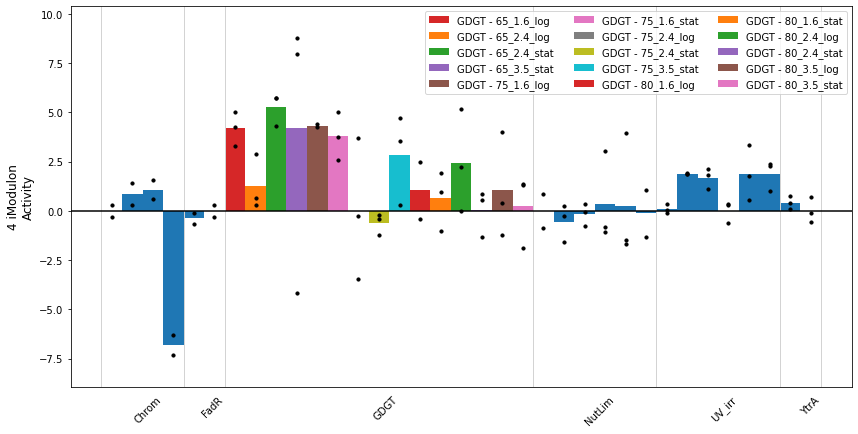

In [92]:
fig, ax = plt.subplots(figsize=(14, 7))

plot_activities(ica_data, 4, highlight='GDGT', ax=ax)

## iModulon 5

- Possible transport iModulon?

<AxesSubplot:xlabel='Gene Start', ylabel='5 Gene Weight'>

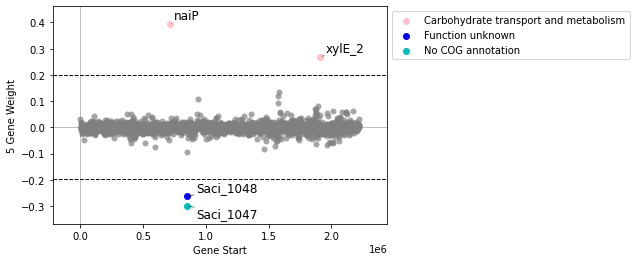

In [93]:
plot_gene_weights(ica_data, 5)

<AxesSubplot:ylabel='5 iModulon\nActivity'>

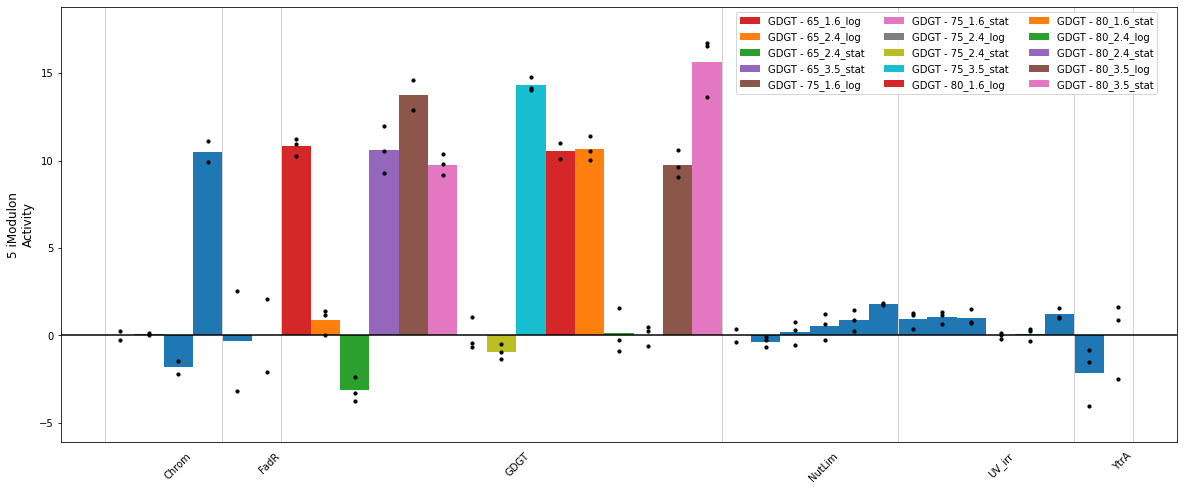

In [94]:
fig, ax = plt.subplots(figsize=(20, 8))

plot_activities(ica_data, 5, highlight='GDGT', ax=ax, legend_kwargs={'bbox_to_anchor': (0.6, 1)})

## iModulon 6

fig, ax = plt.subplots(figsize=(14, 7))

plot_activities(ica_data, 5, highlight='GDGT', ax=ax)

<AxesSubplot:xlabel='Gene Start', ylabel='6 Gene Weight'>

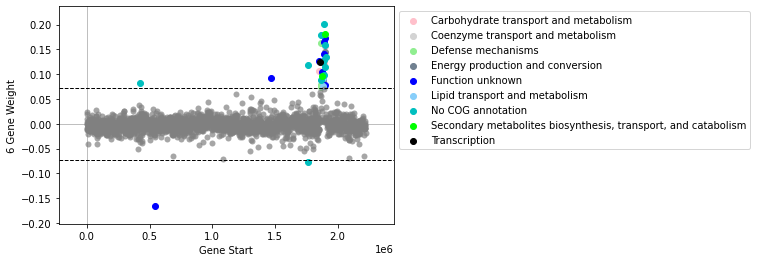

In [95]:
plot_gene_weights(ica_data, 6)

<AxesSubplot:ylabel='6 iModulon\nActivity'>

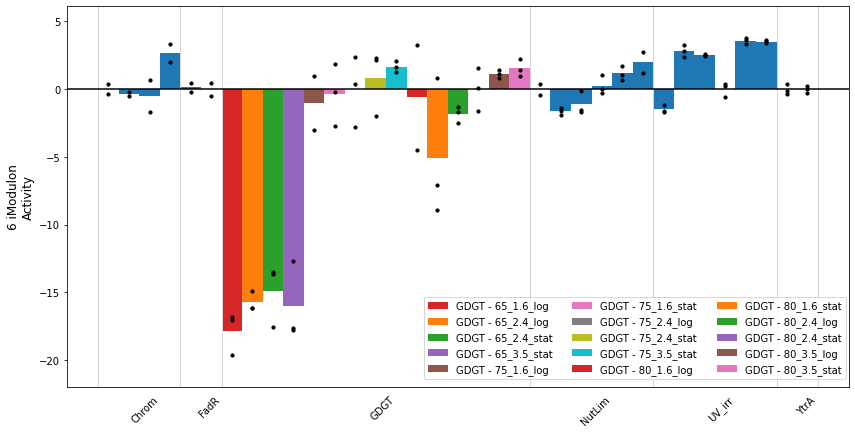

In [96]:
fig, ax = plt.subplots(figsize=(14, 7))

plot_activities(ica_data, 6, highlight='GDGT', ax=ax, legend_kwargs={'bbox_to_anchor': (0.45, 0.25)})

In [97]:
imod = 6

imod_genes = ica_data.M_binarized[imod][ica_data.M_binarized[imod] > 0].index

ica_data.gene_table.loc[imod_genes]

,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS02480,Saci_0517,Saci_0517,Sacid_00510,NaN,426068.0,426739.0,-,hypothetical protein,hypothetical protein,No COG annotation,A0A0U2VVL2,NC_007181.1,NaN
SACI_RS11570,SACI_RS11570,NaN,NaN,NaN,542365.0,542577.0,+,putative integrase,NaN,Function unknown,UPI000AE9D732,NC_007181.1,NaN
SACI_RS11700,Saci_1709,Saci_1709,NaN,NaN,1468477.0,1468635.0,-,TRASH domain-containing protein,NaN,Function unknown,UPI00005526DC,NC_007181.1,NaN
SACI_RS09400,Saci_1947,Saci_1947,Sacid_01934,NaN,1759516.0,1759740.0,+,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3GMH0,NC_007181.1,NaN
SACI_RS11990,SACI_RS11990,NaN,NaN,NaN,1760019.0,1760123.0,+,type II toxin-antitoxin system VapC family toxin,NaN,No COG annotation,UPI0011BDD67A,NC_007181.1,NaN
SACI_RS09835,glpF,Saci_2034,Sacid_02029,NaN,1849204.0,1850085.0,+,aquaporin,Glycerol uptake facilitator protein,Carbohydrate transport and metabolism,A0A0U3FQ15,NC_007181.1,NaN
SACI_RS09840,Saci_2035,Saci_2035,Sacid_02030,NaN,1850246.0,1851289.0,+,DUF917 domain-containing protein,hypothetical protein,Function unknown,A0A0U2NAZ5,NC_007181.1,NaN
SACI_RS09865,Saci_2040,Saci_2040,Sacid_02035,NaN,1855837.0,1856316.0,-,Lrp/AsnC family transcriptional regulator,hypothetical protein,Transcription,A0A0U3GNH8,NC_007181.1,NaN
SACI_RS09895,Saci_2046,Saci_2046,Sacid_02041,NaN,1863675.0,1866395.0,-,HD domain-containing protein,hypothetical protein,Defense mechanisms,A0A0U2WUV5,NC_007181.1,NaN
SACI_RS09900,Saci_2047,Saci_2047,Sacid_02042,NaN,1866379.0,1866594.0,-,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3GQM3,NC_007181.1,NaN


---
testing